In [1]:
import pandas as pd
import numpy as np
import itertools as it
rng = np.random.default_rng(42)
import matplotlib.pyplot as plt 
import pickle

Data:

In [2]:
n_items = 20
df = pd.read_csv(f"/home/tailai/research/multiobjective/data/test_data_n20_exp5.csv")

items_df_visual = pd.DataFrame()
for trial in range(len(df)):
    trial_data = []
    for item in range(1, n_items+1): 
        row = {
            'Science': df[f'value1_item_{item}'][trial],
            'Culture': df[f'value2_item_{item}'][trial],
            'Govern': df[f'value3_item_{item}'][trial],
            'Money': df[f'weight1_item_{item}'][trial],
            'Space': df[f'weight2_item_{item}'][trial],
            'capacity1': df['capacity1'][trial],
            'capacity2': df['capacity2'][trial],
        }
        trial_data.append(row)
    items_df_visual = pd.concat([items_df_visual, pd.DataFrame(trial_data)], ignore_index=True) ## create a new sequential index

test_trial = items_df_visual.iloc[:20,:]

In [3]:
test_trial

,Science,Culture,Govern,Money,Space,capacity1,capacity2
0,0,2,4,-5,-4,-36,-17
1,5,1,2,-4,-2,-36,-17
2,4,3,2,-3,-2,-36,-17
3,2,3,1,-1,-2,-36,-17
4,3,1,1,-2,-2,-36,-17
5,3,1,1,-2,-2,-36,-17
6,0,2,4,-2,-2,-36,-17
7,0,0,1,-2,-4,-36,-17
8,2,2,2,-4,-3,-36,-17
9,1,1,2,-3,-3,-36,-17


Exact Pareto optimal solutions:

In [4]:
n_selected = 5
objectives = []
solutions = []

for combo in it.combinations(range(n_items), n_selected):
    solution = test_trial.iloc[list(combo)]

    # test if the solution exceeds capacity
    if np.abs(solution["Money"].sum()) > np.abs(solution["capacity1"].iloc[0]) or \
          np.abs(solution["Space"].sum()) > np.abs(solution["capacity2"].iloc[0]):
        continue

    # computes objective values
    objective = [
        solution["Science"].sum(),
        solution["Culture"].sum(),
        solution["Govern"].sum()
    ]
    objectives.append(objective)

    solutions.append(combo)

objectives = np.array(objectives) # shape = (num of solutions, num of objectives)
solutions = np.array(solutions) # shape = (num of solutions, num of items)

In [ ]:
# def non_dominated(objectives):
#     pop_size = np.shape(objectives)[0]
#     non_dominated = np.zeros(pop_size, dtype=bool)
#     for i in range(pop_size):
#         dominated = np.zeros(pop_size, dtype=bool)
#         for j in range(pop_size):
#             # dominated[j]= np.all(objectives[i,:] < objectives[j,:])
#             dominated[j]= np.all(objectives[j,:] >= objectives[i,:]) and \
#                           np.any(objectives[j,:] > objectives[i,:])
#         non_dominated[i] = ~np.any(dominated)
#     return non_dominated

# pareto = non_dominated(objectives)

In [5]:
def non_dominated(objectives):
    n_solutions = objectives.shape[0]
    non_dominated = np.ones(n_solutions, dtype=bool)
    for i in range(n_solutions):
        for j in range(n_solutions):
            if i == j:
                continue

            if np.all(objectives[j, :] >= objectives[i, :]) and \
                np.any(objectives[j, :] > objectives[i, :]):
                non_dominated[i] = False
                break

    return non_dominated

pareto_exact = non_dominated(objectives)

In [6]:
exact_pareto_front, exact_pareto_indices = np.unique(objectives[pareto_exact, :], axis=0, return_index=True)

In [7]:
exact_pareto_front

array([[ 3, 12, 18],
       [ 7, 12, 17],
       [ 7, 14, 16],
       [ 8, 10, 17],
       [ 8, 12, 16],
       [ 9,  9, 16],
       [ 9, 13, 15],
       [ 9, 14, 14],
       [ 9, 15, 13],
       [11, 14, 12],
       [11, 15, 11],
       [12, 12, 15],
       [12, 13, 14],
       [14, 12, 13],
       [14, 13, 12],
       [14, 14, 11],
       [15, 11, 12],
       [15, 12, 11],
       [16, 13, 10],
       [17, 11, 10],
       [17, 12,  9],
       [18, 10,  9]])

EDA with elitist nondominated sorting & diversity preservation:

In [8]:
def non_dominated_sort(objectives):
    n_solutions = objectives.shape[0]
    dominated_sets = [[] for _ in range(n_solutions)] # the set of solutions that p dominates
    domination_counts = [0] * n_solutions # the number of solutions that dominate p
    ranks = np.full(n_solutions, -1, dtype=int)           
    fronts = [[]]  

    for p in range(n_solutions):
        for q in range(n_solutions):
            if p == q:
                continue

            if np.all(objectives[p, :] >= objectives[q, :]) and \
                np.any(objectives[p, :] > objectives[q, :]):
                dominated_sets[p].append(q)
            elif np.all(objectives[q, :] >= objectives[p, :]) and \
                np.any(objectives[q, :] > objectives[p, :]):
                domination_counts[p] += 1 
        
        if domination_counts[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)
    
    
    i = 0
    while i < len(fronts) and len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in dominated_sets[p]: 
                domination_counts[q] -= 1
                if domination_counts[q] == 0:
                    ranks[q] = i + 1
                    next_front.append(q)
        
        if next_front:
            fronts.append(next_front)
        i += 1

    dominated_sets = np.array([np.array(s, dtype=int) for s in dominated_sets], dtype=object)
    domination_counts = np.array(domination_counts, dtype=int)
    ranks = np.array(ranks, dtype=int)
    fronts = np.array([np.array(f, dtype=int) for f in fronts if len(f) > 0], dtype=object)

    return  dominated_sets, domination_counts, ranks, fronts

# dominated_sets, domination_counts, ranks, fronts = non_dominated_sort(objectives)

# with open("non_dominated_sort_results.pkl", "wb") as f:
#     pickle.dump((dominated_sets, domination_counts, ranks, fronts), f)

In [9]:
def assign_crowding_distance(objectives):
    distances = np.zeros(objectives.shape[0],  dtype=float)
    for m in range(np.shape(objectives)[1]):
        objective = objectives[:, m]
        sort_indices = np.argsort(objective)[::-1]
        sorted_objective = objective[sort_indices]
        min = sorted_objective[0]
        max = sorted_objective[-1]

        distances[sort_indices[0]] = np.inf
        distances[sort_indices[-1]] = np.inf
        for i in range(1, np.shape(objectives)[0] - 1):
            distances[sort_indices[i]] += (sorted_objective[i + 1] - sorted_objective[i - 1]) \
            / (max - min)
    return distances

In [10]:
def binary_tournament_selection(population, ranks, distances, rng):
    indices = np.arange(len(population))
    i, j = rng.choice(indices, size=2, replace=False)
    if ranks[i] < ranks[j]:
        return i
    if ranks[j] < ranks[i]:
        return j
    else:
        if distances[i] > distances[j]:
            return i
        else:
            return j

In [11]:
def evaluatePopulation(population, n_obj):
    objectives = np.zeros((np.shape(population)[0], n_obj))
    for j in range(np.shape(population)[0]):
        solution = population[j, :]
        objectives[j, :] = np.sum(test_trial.iloc[solution, :3].values, axis=0)
    return objectives

def samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected):
    pop_count = 0
    population = np.zeros((pop_size, n_selected), dtype=int)
    n_cards = np.size(distribution)

    while pop_count < pop_size:
        sample = rng.choice(n_cards, n_selected, p=distribution, replace=False).astype(int)
        if np.abs(np.sum(test_trial.iloc[sample, 3].values)) <= np.abs(money_cap) and \
            np.abs(np.sum(test_trial.iloc[sample, 4].values)) <= np.abs(space_cap):
            population[pop_count, :] = sample
            pop_count += 1
            
    return population

In [12]:
n_cards = n_items
n_selected = 5
n_obj = 3
money_cap = test_trial["capacity1"].iloc[0]
space_cap = test_trial["capacity2"].iloc[0]
pop_size = 1000
training_size = 5


# intial population
distribution = np.ones(n_cards)/n_cards
population = samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected) 
objectives = evaluatePopulation(np.array(population), n_obj)

_, _, ranks, fronts = non_dominated_sort(objectives)
distances_all_solutions = np.zeros(population.shape[0], dtype=float)
for f in fronts:
    distances = assign_crowding_distance(objectives[f, :])
    distances_all_solutions[f] = distances

select_indices = np.array([], dtype=int)
while len(select_indices) < pop_size:
    indice = binary_tournament_selection(population, ranks, distances_all_solutions, rng)
    select_indices = np.concatenate([select_indices, np.array([indice])])
selected_population = population[select_indices]
selected_objectives = objectives[select_indices]

distribution = np.ones(n_cards)
distribution += np.bincount(selected_population.flatten(), minlength=n_cards)
distribution /= np.sum(distribution)


for j in range(training_size):
    prev_distribution = distribution.copy()
    
    population = samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected)
    objectives = evaluatePopulation(np.array(population), n_obj)
    objectives = np.vstack((selected_objectives, objectives))
    population = np.vstack((selected_population, population))  

    _, _, ranks, fronts = non_dominated_sort(objectives)
    select_indices = np.array([], dtype=int)
    for f in fronts:
        if len(select_indices) + len(f) <= pop_size:
            select_indices = np.concatenate([select_indices, f])
        else:
            remaining_size = pop_size - len(select_indices)
            f_distance = assign_crowding_distance(objectives[f, :])
            sort_indices = np.argsort(f_distance)[::-1]
            remaining = f[sort_indices[:remaining_size]]
            select_indices = np.concatenate([select_indices, remaining])
            break

    selected_population = population[select_indices]
    selected_objectives = objectives[select_indices]

    distribution = np.ones(n_cards)
    distribution += np.bincount(selected_population.flatten(), minlength=n_cards)
    distribution /= np.sum(distribution)

    print(f"Iteration {j+1}")

    if np.allclose(distribution, prev_distribution, atol=1e-6):
        print("Converged")
        break

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


In [13]:
_, _, _, fronts = non_dominated_sort(selected_objectives)

pareto_population = selected_population[fronts[0]]
pareto_objectives = selected_objectives[fronts[0]]

In [14]:
pareto_front, pareto_indices = np.unique(pareto_objectives, axis=0, return_index=True)

In [15]:
pareto_front

array([[ 3., 12., 18.],
       [ 7., 12., 17.],
       [ 7., 14., 16.],
       [ 8., 10., 17.],
       [ 8., 12., 16.],
       [ 9.,  9., 16.],
       [ 9., 13., 15.],
       [ 9., 14., 14.],
       [ 9., 15., 13.],
       [11., 14., 12.],
       [11., 15., 11.],
       [12., 12., 15.],
       [12., 13., 14.],
       [14., 12., 13.],
       [14., 13., 12.],
       [14., 14., 11.],
       [15., 11., 12.],
       [15., 12., 11.],
       [16., 13., 10.],
       [17., 11., 10.],
       [17., 12.,  9.],
       [18., 10.,  9.]])

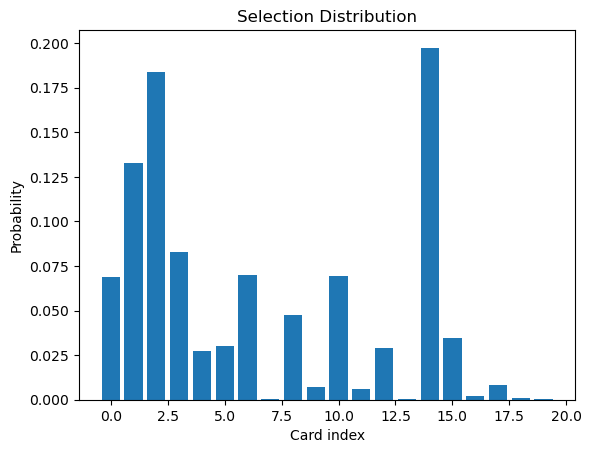

In [16]:
x = np.arange(n_cards)  
plt.bar(x, distribution)
plt.xlabel("Card index")
plt.ylabel("Probability")
plt.title("Selection Distribution")
plt.show()

Original EDA:

In [17]:
n_cards = n_items
n_selected = 5
n_obj = 3
money_cap = test_trial["capacity1"].iloc[0]
space_cap = test_trial["capacity2"].iloc[0]
pop_size = 1000
training_size = 10


distribution = np.ones(n_cards)/n_cards
population = samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected) 
objectives = evaluatePopulation(np.array(population), n_obj)
pareto = non_dominated(objectives)
pareto_front = objectives[pareto,:]
pareto_solutions = population[pareto,:]

distribution = np.ones(n_cards)
distribution += np.bincount(pareto_solutions.flatten(), minlength=n_cards)
distribution /= np.sum(distribution)

for j in range(training_size):
    prev_distribution = distribution.copy()
    
    population = samplePopulation(distribution, money_cap, space_cap, pop_size, n_selected)
    objectives = evaluatePopulation(np.array(population), n_obj)
    objectives = np.vstack((pareto_front, objectives))
    population = np.vstack((pareto_solutions, population))
    pareto = non_dominated(objectives)
    pareto_front = objectives[pareto,:]
    pareto_solutions = population[pareto,:]

    distribution = np.ones(n_cards)
    distribution += np.bincount(pareto_solutions.flatten(), minlength=n_cards)
    distribution /= np.sum(distribution)

    print(f"Iteration {j+1}")

    if np.allclose(distribution, prev_distribution, atol=1e-6):
        print("Converged")
        break

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


In [20]:
pareto_front_original = np.unique(pareto_front, axis=0)
pareto_front_original

array([[ 7., 12., 17.],
       [ 7., 14., 16.],
       [ 8., 10., 17.],
       [ 8., 12., 16.],
       [ 9., 13., 15.],
       [ 9., 14., 14.],
       [ 9., 15., 13.],
       [11., 14., 12.],
       [11., 15., 11.],
       [12., 12., 15.],
       [12., 13., 14.],
       [14., 12., 13.],
       [14., 13., 12.],
       [14., 14., 11.],
       [15., 11., 12.],
       [15., 12., 11.],
       [16., 13., 10.],
       [17., 11., 10.],
       [17., 12.,  9.],
       [18., 10.,  9.]])

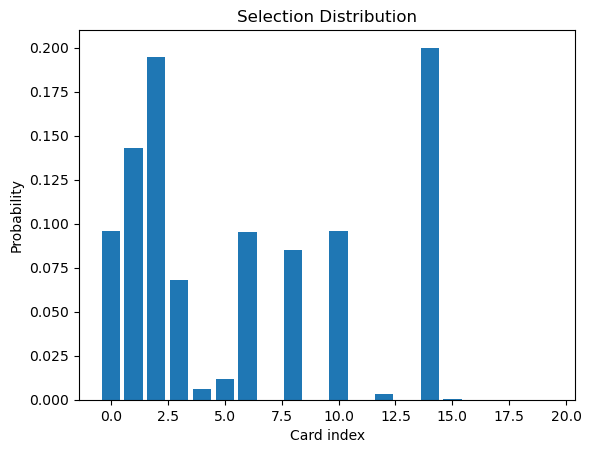

In [21]:
x = np.arange(n_cards)  
plt.bar(x, distribution)
plt.xlabel("Card index")
plt.ylabel("Probability")
plt.title("Selection Distribution")
plt.show()